#  Space Maps

## Ecliptic coordinate system

The ecliptic coordinate system is defined by the ecliptic plan and the position of the Earth WRT the Sun at the Vernal Equinox, i.e. on the Vernal Equinox, we define an x-axis as the line that points from Earth to the Sun. As a result of this, we get a plane based on the orbit of the Earth around the Sun, which allows us to define the z-axis as perpendicular to this plane. The y-axis, then, is the result of the right-hand rule.

Now we have a 3-dimensional vector that can be transformed into spherical coordinates by describing the radius, azimuth, and inclination. If we project those three values into a sphere of radius = 1 we can create a sky map.

On the sky map, we use the following coordinates to describe positions:
* **Longitude** (l): Defined from 0° to 360°. On the Ecliptic Coordinate System, a longitude of 0° is the line of the Vernal Equinox
* **Latitude** (b): Defined with a range of \[-90°, 90°] (from south pole to north pole of the *sphere*). Values of 0° lie on the equator

As a result, l=0°, b=0° is the Vernal Equinox point.

![eclipticCoordinateSystem](/home/einhard/Documents/projects/pythonSpaceProblems/images/ecliptic_coordinate_system.png)

When doing space position computations, we use the J2000 ecliptic reference; this is the state of the ecliptic coordinate system on January 1, 2000, and is used to avoid errors that arise from slight wobbles in the Earth's orbit.

## Computing and plotting a sky map

In [4]:
import datetime
import spiceypy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

spiceypy.furnsh('/home/einhard/Documents/projects/zData/spicepy/meta/_kernels.txt')

datetime_UTC = datetime.datetime.utcnow().strftime('%Y-%m-%dT%H:%M:%S')

datetime_ET = spiceypy.utc2et(datetime_UTC)

In [12]:
# Computing coordinates for different Solar System bodies as seen from Earth.

solsys_df = pd.DataFrame()

solsys_df['ET'] = [datetime_ET]
solsys_df['UTC'] = [datetime_UTC]

# Creating a dictionary of body names and NAIF ID. Note that for Mars we are using its barycentre
SOLSYS_DICT = {'SUN':10, 'VENUS':299, 'MOON':301, 'MARS':4}

We now use a for-loop to compute the directional vector to each object as seen from Earth. To do this, we use the [spkezp](https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/cspice/spkezp_c.html) function. What spkezp does is return the position of a body *relative* to an observing body. We then use [recrad](https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/cspice/recrad_c.html) to convert rectangular coordinates to spherical (range, ascension, declination)

In [13]:
for body_name in SOLSYS_DICT:

    # Computing the directional vector Earth - body in ECLIPJ2000 using LT+S light time correction. Note that spkezp returns a directional vector and light time, and we only use the first value here
    solsys_df[f'dir_{body_name}_wrt_earth_ecl'] = solsys_df['ET'] \
        .apply(lambda x: spiceypy.spkezp(targ=SOLSYS_DICT[body_name],
                                         et=x,
                                         ref='ECLIPJ2000',
                                         abcorr='LT+S',
                                         obs=399)[0])
    
    # Computing lat-long of target body in radians in ECLIPJ2000 using recrad (which returns distance, longitude, and latitude; thus, we apply [1] and [2])
    solsys_df[f'{body_name}_long_rad_ecl'] = solsys_df[f'dir_{body_name}_wrt_earth_ecl'] \
        .apply(lambda x: spiceypy.recrad(x)[1])

    solsys_df[f'{body_name}_lat_rad_ecl'] = solsys_df[f'dir_{body_name}_wrt_earth_ecl'] \
        .apply(lambda x: spiceypy.recrad(x)[2])

In [14]:
solsys_df

,ET,UTC,dir_SUN_wrt_earth_ecl,SUN_long_rad_ecl,SUN_lat_rad_ecl,dir_VENUS_wrt_earth_ecl,VENUS_long_rad_ecl,VENUS_lat_rad_ecl,dir_MOON_wrt_earth_ecl,MOON_long_rad_ecl,MOON_lat_rad_ecl,dir_MARS_wrt_earth_ecl,MARS_long_rad_ecl,MARS_lat_rad_ecl
0,6.626402e+08,2020-12-30T22:42:49,"[24068786.23870824, -145113925.3717234, 6957.8...",4.876754,0.000047,"[-45198005.18225278, -228331722.04719916, 2861...",4.516966,0.012293,"[-125601.09623821802, 368830.8906589968, 17433...",1.899017,0.044714,"[118893539.17018397, 59580695.74880995, 197076...",0.464548,0.014818


## Map Projections

With the coordinates in hand, we can now project our data into a map. However, there are many types of [projections](https://www.giss.nasa.gov/tools/gprojector/help/projections/) that can be used.

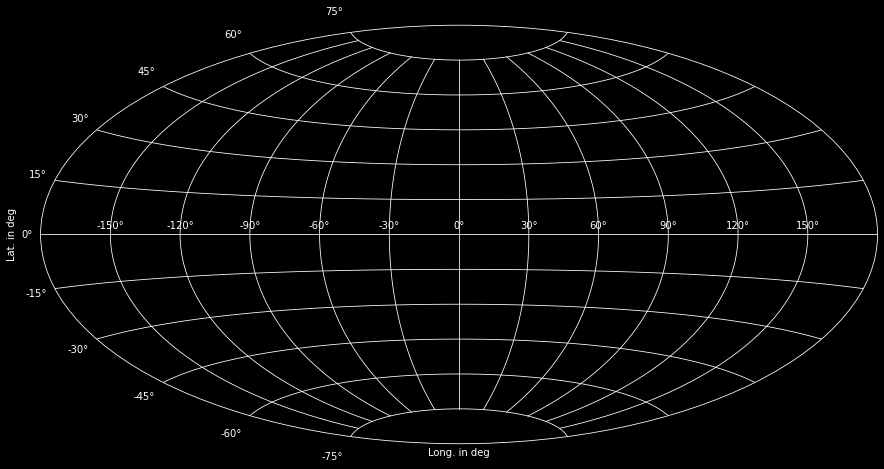

In [24]:
# Creating different projections\
plt.style.use('dark_background')
plt.figure(figsize=(15,12))
plt.subplot(projection='aitoff')
plt.grid(True)
plt.xlabel('Long. in deg')
plt.ylabel('Lat. in deg')
plt.show()

The plot above shows longitude values of \[-180, 180], but the Ecliptic Coordinate System uses \[0, 360]. To get around this issue we use a for-loop that iterates through all longitude values to create a column that can be used for this projection.

Values that are larger than pi (180) exceed the plotting range of matplotlib's projection. Thus, the modulo operator is applied with pi, and the remainder is between 0 and pi - this must be translated into a range of \[-180, 0] on the projection, so pi is subtracted. Then, the result is multiplied with -1 to invert the x-axis.

In [25]:
# Before we plot the data, we need to convert the longitude data into a
# matplotlib compatible format. We computed longitude values between 0 and
# 2*pi (360 degrees). matplotlib expects values between -pi and +pi. Further,
# sky maps count from 0 degrees longitude to the left. Thus we need also to
# invert the longitude values

for body_name in SOLSYS_DICT:
   solsys_df[f'{body_name}_long_rad4plot_ecl'] = solsys_df[f'{body_name}_long_rad_ecl'] \
       .apply(lambda x: -1*((x % np.pi) - np.pi) if x > np.pi else -1*x)


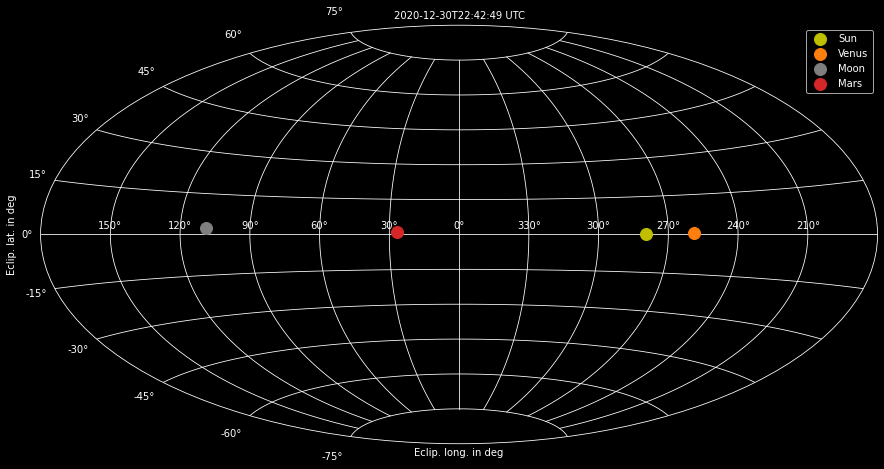

In [26]:
# Plotting a skymap

plt.style.use('dark_background')
plt.figure(figsize=(15,12))
plt.subplot(projection='aitoff')

plt.title(f'{datetime_UTC} UTC', fontsize=10)

BODY_COLOR_ARRAY = ['y', 'tab:orange', 'tab:gray', 'tab:red']

for body_name, body_color in zip(SOLSYS_DICT, BODY_COLOR_ARRAY):
    plt.plot(solsys_df[f'{body_name}_long_rad4plot_ecl'], \
             solsys_df[f'{body_name}_lat_rad_ecl'], \
             color=body_color, marker='o', linestyle='None', markersize=12, \
             label=body_name.capitalize())

# Replacing standard x ticks with ecliptic coordinates
plt.xticks(ticks=np.radians([-150, -120, -90, -60, -30, 0,
                             30, 60, 90, 120, 150]),
                             labels=['150°', '120°', '90°', '60°', '30°', '0°', \
                                     '330°', '300°', '270°', '240°', '210°'])

plt.xlabel('Eclip. long. in deg')
plt.ylabel('Eclip. lat. in deg')

plt.legend()
plt.grid(True)

plt.savefig('/home/einhard/Documents/projects/pythonSpaceProblems/figures/eclipj2000_skyMap.png')